# **Homework 3: Semantic Role Labeling using LSTM and Encoder-Decoder Architectures**
## CS4740/5740 Fall 2023

No part (code, documentation, comments, etc.) of this notebook or any assignment-related artefacts were generated/created, refined, or modified using generative AI tools such as Chat GPT. Cite this notebook as:

>Vivian Nguyen, Sasha Boguraev ∗, Han Xia ∗, Travis Zhange ∗, Vinh Nguyen ∗, Sienna Hu ∫, Gavin Fogel ∫, Vivian Chen ∫,  Benjamin Hu ∫. 2023. CS 4740 FA'23 HW3: Semantic Role Labeling using LSTM and Encoder-Decoder Architectures. GitHub. https://github.coecis.cornell.edu/cs4740-fa23-public/hw3-fa23/.
    ∗equal contribution, software creators, ordered alphabetically
    ∫equal contribution, software testers, ordered alphabetically

Acknowledgments. This work is inspired from the assignment "CS 4740 FA'22 HW3: Semantic Role Labeling" developed by Heather Zheng and Han Xia, adapting from Ruoqi Zhang, Magd Bayoumi, Kai Zou, Wenyi Guo, Abigail See, Sahil Chopra, and Chris Manning


### Deadlines

Please follow Ed #[] for updates on HW3 assignment, all the submission instructions and grouping information will be posted there; it can be misleading to just follow the "git commit" trail.

Project submission deadline: **Wednesday November 8, 2023**.

This assignment will **not** have a required milestone submission, but we strongly recommend completing the optional milestone by **Monday, October 30, 2023**. 

### Documentation
All documentation will be hosted within each python file. You do not need to read any documentation of classes you don't modify, but you should understand the general purpose of each method you use even if you don't modify said methods. 

Policies. All the policies described on the course website are applicable as is (including the policy on academic integrity and the use of generative AI tools), for more information, see: https://www.cs.cornell.edu/courses/cs4740/2023fa/.

### Baselines
In the assignment, you will be implementing two models-- LSTMTagger and SRL Encoder-Decoder model. <br>
The baselines are: **LSTMTagger: 0.245** and **SRL Encoder-Decoder: 0.210**. 


# **Introduction**
---

Semantic Role Labeling (**SRL**) is the task of automatically labelling the semantic roles of each argument according to each predicate in a passage.

- **Predicates** (e.g., bought, sell, purchasing) represent events, and each sentence can have more than one predicate.
- **Semantic roles** express the abstract roles that predicate arguments can take in the event.

Typical semantic arguments include Agent, Patient, and Instrument, and also adjunctive arguments indicating Locative, Temporal, Manner, Cause, and other aspects.

Recognizing and labeling semantic arguments is a key task for answering "Who", "When", "What", "Where", and "Why" questions in Information Extraction, Question Answering, Summarization, and, in general, in all NLP tasks in which some kind of semantic interpretation is needed.

The following sentence, exemplifies the annotation of semantic roles:

[**Arg0 He**] wouldn't accept [**Arg1 anything of value**] from [**Arg2 those he was writing about**].

Here, the roles for the **predicate 'accept'** (that is, the roleset of the predicate) are defined in the PropBank Frames scheme as:

- **Arg0**: Agent (who/what is doing the event) <br></br>
- **Arg1**: Patient (who/what is the target of said event, usually direct object) <br></br>
- **Arg2**: Instrument, Benefactive, Attribute (the indirect object of said event, ex: how the event was done) <br></br>
- **ArgM-LOC**: Locative modifiers indicate where some action takes place. The notion of a locative is not restricted to physical locations, but abstract locations are being marked as LOC as well, as "[in his speech]-LOC he was talking about …".  <br></br>
- **ArgM-TMP**: Temporal ArgMs show when an action took place, such as "in 1987", "last Wednesday","soon" or "immediately". Also included in this category are adverbs of frequency (eg. often always, sometimes), adverbs of duration (for a year/in an year), order (eg. first), and repetition (eg. again)..  <br></br>

For this homework, the predicate is given for every sentence. Your task is to implement 2 models to predict A0/A1/A2/ArgM-LOC/ArgM-TMP.




## **Advice (please read)**

---
1. We strongly encourage you to enable GPU support as well as redeem your free Colab credits for access to better GPUs through Google Colab. To do so, go to `Runtime` --> `Change Runtime Type` --> Dropdown box below `Hardware Accelerator` --> `GPU`. This will help your models train *much* faster!
2. Please read through the entire notebook before you start coding. That might inform your code structure.
3. An assignment outline is found below; please consult it.
4. There are questions inside of the questions notebook that might be best answered as you concurrently work on the model. Before each section, we highly recommend looking ahead at the questions for that section and jotting down answers ahead of time!!!

<a name="outline"></a>
## **Assignment Outline and Grading Breakdown**
- [Part 0](#part0) Setting Everything Up
- [Part 1](#part1) Prepping the Data
- [Part 2](#part2) LSTM Encoder Model
  - [Implementation](#part2.1)
      - Initialization
      - Forward
  - [Entity Level F1 Score Calculation](#part2.2)  
  - [Questions](#part2.3)        
- [Optional Milestone](#milestone) Submission
- [Part 3](#part3) Encoder-Decoder Model
  - [Preprocess the Data](#part3.1)
  - [Implementation](#part3.2)
    - Encoder
      - Initialization
      - Forward
    - Decoder
      - Initialization
      - Forward
      - Step
  - [Entity Level F1 Score Calculation](#part3.3)
  - [Questions](#part3.4)
- [Part 4](#part4) Analysis
- [Part 5](#part5) Submission Creation



**A brief note on the baselines:** To give you some breathing room for your implementation, our baselines are *not* perfect implementations. Correct implementations should therefore outperform our baselines.

<a name="part0"></a>
[[^^^]](#outline)
# **Part 0: Setting Everything Up**
Assuming that you've followed setup.ipynb and successfully setup (or added a shortcut to) the hw3-fa23 folder, the following cells will install any external libraries and needed packages to run the HW3 assignment. Before proceeding, be sure to run the second code cell to ensure that the installation is successful.

> Tip. It is possible to run out of GPU cycles on Colab, even if the GPU is sitting idle (but connected); we strongly recommend that you use CPU while you experiment, develop your code, then transition to using a GPU to run the final experiments.

In [ ]:
# Note that it would be normal for this cell to take noticably longer time given the size of the packages.
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/CS4740/hw3-fa23"

from colab.file_utils import load_required
load_required(install_packages=["sentencepiece", "-U gensim", "torch==2.0.1"])

In [ ]:
from IPython.display import display

try:
    from utils.utils import success, colored
    print(colored("Installation successful!\n", "green"))
    display(success())
except ImportError:
    print("\033[31mInstallation failed, please retrace your steps ...")

### Imports
A few imports that will be needed throughout this notebook are imported below. Within this notebook, feel free to import and/or install packages (a lot of the packages you may need should already be available) as you see fit;  
>**HOWEVER**, you are __not__ allowed to modify the imports in any of the Python source files; further, please do not modify (delete lines, change method signatures, etc.) above or below the `TODO` placeholders within the Python source files.

In [ ]:
from collections import Counter, namedtuple
from itertools import chain
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Set, Union
import sys

# External imports
import gensim
import gensim.downloader as api
import nltk
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

# Internal imports
from srl.models.decoder import Decoder
from srl.models.encoder import Encoder
from srl.models.lstm_tagger import LSTMTagger

from srl.train_and_eval.srl_trainer import srl_train_and_evaluate
from srl.train_and_eval.tagger_trainer import tagger_train_and_evaluate

from srl.utils.constants import SRL_MAP, SRL_FRAMES
from srl.utils.srl_utils import *
from srl.utils.vocab import Vocab

from srl.SRL import SRL

from utils.styling import *
from utils.utils import *


#### Finally, we can grab the data we'll be using for this assignment:

In [ ]:
BASE_DIR = os.path.abspath(".")
DATA_DIR = os.path.join(BASE_DIR, "dataset")

with open(os.path.join(DATA_DIR,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(DATA_DIR,'valid.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(DATA_DIR,'test.json'), 'r') as f:
     test = json.loads(f.read())

<a name="part1"></a>
# Part 1: Prepping the Data
Currently, the dataset has four fields:
1. 'text' represents the tokenized sentences from all documents (Type: `List[List[String]]` )

2. 'verb_index' represents the **relative position** of the **predicate verb** in the sentence. (Type: `List[int]`)
  - Example:  ["He", "would", "n't", "**accept**", "anything", "of", "value", "from", "those", "he", "was", "writing", "about", "."]
    - verb_index = 3


3. 'srl_label' is the semantic role label of every token. (Type: `List[List[ String]]` )

4. 'word_indices' is the index of every word token (same as howework 1&2 'index', Type: `List[List[int]]`)

We could try printing out the second training sentence as an example of the dataset.
The verb_index here is 4, which means the fifth word of the sentence, "**coordinated**", is the predicate.

In [ ]:
print(train['verb_index'][1])
print(train['text'][1])
print(train['words_indices'][1])
print(train['srl_frames'][1])

### **Converting Labels to Numerical Values**
In addition to converting our tokens into vector representations, we also need to convert our labels to numerical representations.

For example, say we had two labels: "O", "B-ARG0". We could numerically represent these labels in a dictionary as Label "0" and Label "1": `{"O":0, "B-ARG":1}`.

You can find this function, named **encode_srl_category**, inside of `srl/utils/srl_utils.py`


We have also provided the `pad_sents` function, which pads all sentences to be the same length, specifically the length of the longest input sentence, using the provided `pad_token`.

Finally, we have provided the `Vocab` class that represents the corpus as a `Vocab` object with several helper functions. These are used to preprocess the training set for you.

You can find this `pad_sents` also in the `srl_utils.py` file and the `Vocab` class inside of `srl/utils/vocab.py`

# **Part 2: LSTM Encoder Model**
<a name="part2"></a>

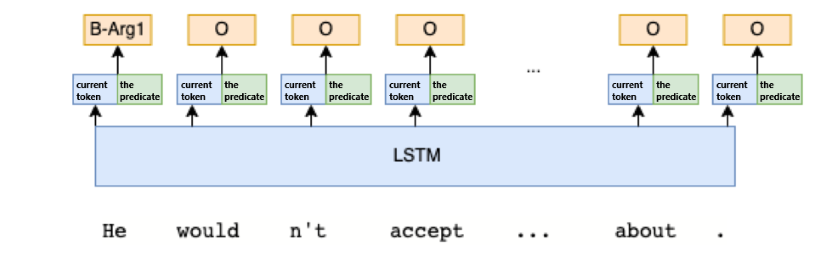

<a name="part2"></a>

We will be using a single layer LSTM to predict Semantic Role Labels (**SRLs**) as our first model.

Input: word tokens $\vec{x}_1,\vec{x}_2, \dots, \vec{x}_k$ and index $i$ of the verb ($\vec{x}_i$) in the sentence

Output: tags $\vec{tag}_1,\vec{tag}_2, \dots, \vec{tag}_k$ corresponding to the tag for a token $i$ in the sentence

By the end, our LSTM model should be able to:
1.   Pass each word embedding to the LSTM and get the corresponding LSTM hidden layer. In the diagram above, each token's respective word embedding is represented by the blue unlabeled rectangles with "current token" text. <br></br>
2.   Get hidden state of the predicate in the sentence (the green rectangle in the diagram above). In the diagram above, the hidden state of the predicate is represented by the green unlabeled rectangles with "the predicate" text. **Note!** They represent the same hidden state since we only have a singular predicate.  <br></br>
2.   Concatenate the hidden states with the predicate hidden state. <br></br>
3.   Pass the concatenated embedding through a linear layer to generate output <br></br>





In this part, you need to implement an LSTM Encoder in PyTorch. Since you already understand how to implement RNNs from HW2, you are now allowed, **and encouraged** to use the torch.nn.LSTM function. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

(**Tip**: read the documention and understand the parameter: "batch_first")

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

print('initialize train vocabulary ..')
src_vocab = Vocab.from_corpus(train['text'], remove_frac=0.3)

In [ ]:
train_data = list(zip(train['text'],train['verb_index'],encode_srl_category(train['srl_frames'])))
val_data = list(zip(val['text'], val['verb_index'], encode_srl_category(val['srl_frames'])))

<a name="l2"></a>

## 2.1 Implementing the LSTMTagger Class
Inside the `srl/models/lstm_tagger.py` file, you'll find an unfinished declaration of a LSTMTagger class.

Work through each section of the class and be sure to handle all **### TODO**s (5 total)!

- TODO 1: <br></br>
    - Initialize the layers of your model <br></br>
- TODO 2 - 5: <br></br>
    - Fill in the forward function of the LSTMTagger class that correctly faciliates each forward pass of the model

#### **Train your LSTM Encoder Model**

Once you've finished writing the LSTMTagger class, you can build the model and train it by using the cell below:

> You can find the `tagger_train_and_evaluate` method inside of `srl/training_and_eval/tagger_trainer`

In [ ]:
embed_dim = 64
hidden_dim = 64
weight = torch.ones(len(SRL_MAP))
weight[0] = 0.25
criterion = nn.NLLLoss(weight=weight)
lstm = LSTMTagger(src_vocab, embed_dim, hidden_dim=hidden_dim, output_dim=len(SRL_MAP), vocab_size=len(src_vocab)).to(get_device())
loss = tagger_train_and_evaluate(10, lstm, train_data, val_data, criterion, min_loss=0.2, lr= .05)

<a name="part2.2"></a>
## 2.2 Get Entity Level F1 Score on the Validation Set

Run the cells below to calculate your F1 score on the validation set (no modifications needed):

In [ ]:
# Create predictions on validation data
inv_srl_map={SRL_MAP[key]:key for key in SRL_MAP}
val_predict = []
val_true = []
val_idx = []

for idx in range(len(val_data)):
  out = lstm.forward([val_data[idx][0]], torch.tensor([val_data[idx][1]]))
  _, predicted = torch.max(out, 2)

  len_sent = len(val_data[idx][0])
  result = predicted.cpu().numpy()[0]

  for t in range(len_sent):
    val_predict.append(inv_srl_map[result[t]])
    val_true.append(inv_srl_map[val_data[idx][2][t]])

  val_idx.extend(val['words_indices'][idx])

In [ ]:
# Get validation score
y_pred_dict = format_output_labels(val_predict, val_idx)
y_true_dict = format_output_labels(val_true, val_idx)

print(str(mean_f1(y_pred_dict, y_true_dict)))

In [ ]:
# Save our model!
# Don't change saved model name here

lstm.save_model("lstm.pth")
lstm.load_model("lstm.pth")

<a name="part2.3"></a>
## 2.3 Questions

Refer to the **Student_CS_4740_FA23_HW3_Questions** python notebook, Section 2.

<a name="milestone"></a>
# [Optional] Milestone Submission

Please run the code below to generate the submission zip file. Please make sure to specify both student's netid into `netid`. For instance, if my partner's and my netid are abc123 and cd234, `netid` should be abc123_cd234. While the milestone submission is optional, we strongly encourage you to submit your results to the Gradescope pseudo-scorer assignment to see your model's performance on the test data.

In [ ]:
lstm_weights_path = "lstm.pth"
netid = ""

In [ ]:
!python make_submission.py --lstm_weights $lstm_weights_path --netid $netid

<a name="part3"></a>
# **Part 3: Encoder-Decoder Model**

<a name="part3"></a>
Now, one might ask how we can utilize an Encoder-Decoder model to do this same task. To faciliate this, we can convert the Semantics Role Labeling (SRL) task into the format of a Question and Answer task.

#### For example, instead of trying to label a sentence like so:

    [*Arg0 He*] would n't accept [*Arg1 anything of value*] from [*Arg2 those he was writing about*] .  

#### We can instead feed a model a predicate and it's corresponding sentence:

    "accept" + "He wouldn't accept anything of value from those he was writing about.";

#### And ask the model: what is _ in this sentence? from our list of [ARG0, ARG1, ARG2, ARGM_TMP, ARGM_LOC]

---

We move to convert each possible tag into 5 question and answer pairs.

Input: *predicate [SEPT] tokenized_seperated_sentence [SEPT] label we want to find*, where [SEPT] is a separator token.

Output: the sequence that corresponds with that label, or empty if that label is not in this sentence.

#### For Example:

- Input 1: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG0
  - Output 1: $<s>$ He $</s>$ <br></br>

- Input 2: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG1
  - Output 2: $<s>$ anything of value $</s>$ <br></br>

- Input 3: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG2
  - Output 3: $<s>$ $</s>$ (Explanation: because there's no ARG2 in this sentence) <br></br>

- Input 4: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-TMP
  - Output 4: $<s>$ $</s>$ <br></br>

- Input 5: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-LOC
  - Output 5: $<s>$ $</s>$ <br></br>


---

## Beware!
The following section has a lot of mathematical notation but don't let that scare you! You might need to reread this section a couple of times in order to fully understand it, but that's okay! Don't try to force yourself to understand it all at once, rather, try to gain a better understanding behind the logic of this architecture as you build and debug your model.

---

Given the input, we want to use a seq2seq model to predict output. In this section, we describe the training procedure for the proposed encoder-decoder system, which uses a Bidirectional LSTM Encoder and a Unidirectional LSTM with attention Decoder. We'll recap the theoretical component here and in the modules where you are writing code, we will repeat the steps more explicitly in an algorithmic manner.

<Insert diagram here>

Given a sentence in the source language, we look up the word embeddings from an embeddings matrix, yielding $x_1,\dots, x_n$ ($x_i \in R^{e}$), where n is the length of the source sentence and e is the embedding size. We feed these embeddings to the bidirectional encoder, yielding hidden states and cell states for both the forwards (→) and backwards (←) LSTMs. The forwards and backwards versions are concatenated to give hidden states $h_i^{enc}$ and cell state $c_i^{enc}$:


$$h_i^{enc} = [\overrightarrow{h_i^{enc}}; \overleftarrow{h_i^{enc}}] \text{ where }h_i^{enc} \in R^{2h}, \overrightarrow{h_i^{enc}}, \overleftarrow{h_i^{enc}} \in R^{h}$$

$$c_i^{enc} = [\overrightarrow{c_i^{enc}}; \overleftarrow{c_i^{enc}}] \text{ where }c_i^{enc} \in R^{2h}, \overrightarrow{c_i^{enc}}, \overleftarrow{c_i^{enc}} \in R^{h}$$


We then initialize the decoder’s first hidden state $h_0^{dec}$ with a linear projection of the encoder’s final hidden state

$$h_0^{dec} = W_h[\overrightarrow{h_n^{enc}}; \overleftarrow{h_0^{enc}}] \text{ where }h_0^{dec} \in R^{h}, W_h \in R^{h \times 2h}$$

And first cell state $c_0^{dec}$ with a linear projection of the encoder’s final cell state

$$c_0^{dec} = W_c[\overrightarrow{c_n^{enc}}; \overleftarrow{c_0^{enc}}] \text{ where }c_0^{dec} \in R^{h}, W_c \in R^{h \times 2h}$$


With the decoder initialized, we must now feed it a target sentence. On the $t^{th}$ step, we look up the embedding for the $t^{th}$ word, $y_t \in R^{e}$. We then concatenate $y_t$ with the combined-output vector $o_{t−1} \in R^{h}$ from the previous timestep (we will explain in detail what this is later, but it is just the output from the previous step) to produce $\bar{y_t} \in R^{e+h}$. Note that for the first target (i.e. the start token), $o_0$ is usually a zero-vector (but it can be random or a learned vector as well). We then feed $y_t$ as input to the decoder.

$$ h_t^{dec} = Decoder(\bar{y_t}, (h_{t-1}^{dec},c_{t-1}^{dec}))\text{ where }h_{t-1}^{dec} ∈ R^{h}$$

We can take the decoder hidden state $h_t^{dec}$ and concatenate with attention context vector $a_t$
$$u_t = [h_t^{dec},a_t] \in R^{3h}$$

Then we pass $u_t$ through a linear layer and an activation function like tanh to obtain our combined-output vector $o_t$:

$$v_t = W_v u_t \text{ where } W_v \in R^{h \times 3h}, v_t \in R^{h}$$

Then, we produce a probability distribution $P_t$ over target words at the $t^{th}$ timestep.

$$P_t = Softmax(W_{v_{target}} v_t) \text{ where }P_t \in R^{V_{target}}, W_{v_{target}}\in R^{V_{target} \times h}$$


Here, $V_{target}$ is the size of the target vocabulary. Finally, to train the network we then compute the softmax cross entropy loss between $P_t$ and $g_t$, where $g_t$ is the one-hot vector of the target word at timestep t:

$$Loss(Model) = CrossEntropy(P_t, g_t)$$

Now that we have described the model, let’s try implementing it for the SRL task.

**How we get $a_t$ attention context vector:**

At the beginning of the decoder step, first we need to project encoder hidden states from $ R^{2h}$ to $ R^{h}$

$$h_i^{enc-projection} = W_a h_i^{enc}, W_a \in R^{h \times 2h}, \forall i$$

Then at each decoder step, we compute dot product similarity between $h_t^{dec}$ and $h_i^{enc-projection}, \forall i$:
$$score(h_t^{dec},h_i^{enc-projection}) = h_t^{dec} \cdot h_i^{enc-projection}$$
Softmax the scores to create vector of weights:
$$\alpha_t = softmax(score(h_t^{dec},h_i^{enc-projection}),\forall i)$$
Take the weighted average over all encoder hidden states
$$a_t = \alpha_t \cdot h_t^{enc} \in R^{2h}$$

<a name="part3.1"></a>
## 3.1 Preprocess the data

The code here converts raw dataset to the input and output format mentioned above. No modifications necessary.

The following cell builds a combined vocab dictionary for input (source) and output (target). Both will share the same vocabulary.

In [ ]:
train_src_corpus = generate_source_corpus(train['text'], train['verb_index'])
train_tgt_corpus = generate_target_corpus(train['text'], train['verb_index'], train['srl_frames'], train['words_indices'])
train_data = list(zip(train_src_corpus, train_tgt_corpus))

val_src_corpus = generate_source_corpus(val['text'], val['verb_index'])
val_tgt_corpus = generate_target_corpus(val['text'], val['verb_index'], val['srl_frames'], val['words_indices'])
val_data = list(zip(val_src_corpus, val_tgt_corpus))

#generate src_vocab
src_vocab = Vocab.from_corpus(np.array(train_src_corpus + val_src_corpus+train_tgt_corpus+val_tgt_corpus), remove_frac=0.3)
tgt_vocab = src_vocab

You can print out our converted inputs & outputs here:

In [ ]:
print(f"train['text'] is {train['text'][1]}")
print(f"train['srl_frames'] is {train['srl_frames'][1]}")
print(f'train_src_corpus is {train_src_corpus[7]}')
print(f'train_tgt_corpus is {train_tgt_corpus[7]}')

The following cell loads pretrained GloVe embeddings and stores the embedding for each word in the vocabulary to `src_embeddings`. These embeddings will be used to initialize the learned embeddings in the models:

In [ ]:
model = api.load("glove-wiki-gigaword-300")
torch.manual_seed(1)

# Obtain src_embeddings
src_embeddings = []
for i, word in enumerate(src_vocab.word2id.keys()):
    try:
        src_embeddings.append(model[word])
    except:
        src_embeddings.append(torch.rand(300))

src_embeddings = np.stack(src_embeddings, 0)
src_embeddings = torch.from_numpy(src_embeddings)

<a name="part3.2"></a>
## 3.2 Implementation
Your next task is to implement the Encoder-Decoder model by completing the **#TODOs** found in `srl/models/encoder.py` (5 TODOS) and `srl/models/decoder.py` (5 TODOS).

For the `Encoder`:
- TODO 1: <br></br>
    - Initialize the layers of your model <br></br>
- TODO 2 - 5: <br></br>
    - Fill in the forward function of the `Encoder` class that correctly faciliates each forward pass of the model

For the `Decoder`:
- TODO 1: <br></br>
    - Initialize the layers of your model <br></br>
- TODO 2: <br></br>
    - Using what you've learned from writing the forward functions for both the `LSTMTagger` and the `Encoder`, fill in the forward function of the `Decoder` class <br></br>
- TODO 3-5: <br></br>
    - Write the code that facilitates a single step done by the model after each time step.


Once you've finished implementing both classes. We can now use the SRL class from `srl/SRL.py` which puts together the LSTM Encoder and Decoder with several helper methods that allow the model to generate outputs.

**No** modifications to the SRL class are necessary.

Run the following cells to train and save your model:

In [ ]:
embed_size = 300
hidden_size = 512

np.random.seed(1234)
torch.manual_seed(1234)

epochs = 8
train_batch_size = 128
clip_grad = 2
log_every = 100
valid_niter = 500
model_save_path="srl.ckpt"
device = get_device()

model = SRL(
    embed_size,
    hidden_size,
    src_vocab,
    tgt_vocab,
    device=device,
    pretrained_source=src_embeddings
)

In [ ]:
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define each of the variables then you can run this command!
srl_train_and_evaluate(
    model,
    train_data,
    val_data,
    optimizer,
    train_batch_size,
    clip_grad,
    log_every,
    valid_niter,
    model_save_path,
    epochs
)

<a name="part3.3"></a>
## 3.3 Get Entity level F1 score on the validation set

In [ ]:
# First load the model in
model = SRL.load(model_save_path)
model.to(get_device())

We can now use an approximate search algorithm called **beam search** to generate our model outputs and transform them to the same format as our LSTMTagger model so that we can compare their performance.

#### Run the cells below to generate the new model predictions

In [ ]:
# Use beam search to generate output
val_data_src = [src for src, _ in val_data]
val_pred = generate_predictions_using_beam_search(model, val_data_src)

In [ ]:
y_pred_model2_dict = format_output_labels(val_pred, val_idx)
y_true_model2_dict = format_output_labels(val_true, val_idx)
print(str(mean_f1(y_pred_model2_dict, y_true_model2_dict)))

<a name="part3.4"></a>
## 3.4 Questions

Refer to the **Student_CS_4740_FA23_HW3_Questions** python notebook, Section 3.

<a name="part4"></a>
# **Part 4: Analysis**

Refer to the **Student_CS_4740_FA23_HW3_Questions** python notebook, Section 4.

<a name="part5"></a>
# **Part 5: Submission Creation**

Run the following code below to create a submission zip file. Please make sure to specify both student's netid into `netid`. For instance, if my partner's and my netid are abc123 and cd234, `netid` should be abc123_cd234. 

**Note**: The predictions for the Encoder-Decoder model does take a noticeable amount of time, so don't worry if the cell below runs for a while

In [ ]:
lstm_weights_path = ""
srl_weights_path = ""
netid = "abc123_cd234"

In [ ]:
!python make_submission.py --lstm_weights $lstm_weights_path --srl_weights $srl_weights_path --netid $netid